In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import timedelta, time
import datetime
import matplotlib.pyplot as plt
import os
import lightgbm as lgbm
from sklearn.metrics import accuracy_score, log_loss
from parameters import top_tickers, ibkr_info

from utils import load_tickers, load_dfs, df_between, sample_ticker_datetimes
#from features import calc_single_ticker_targets, calc_all_tickers_targets, calc_single_ticker_feats, calc_all_tickers_feats, load_feats, load_single_target, single_target_3
from features import *
from strategy import Strategy

# import seaborn as sns
# sns.set()


DATA_PATH = '../finance_data'

In [67]:
load_tickers(data_prefix=DATA_PATH, tickers=np.array(list(ibkr_info.keys()))[:], start_date=datetime.datetime.strptime("20190101", "%Y%m%d").date(), end_date=datetime.datetime.today().date() + timedelta(days=1), period=2)

100%|██████████| 30/30 [14:17<00:00, 28.60s/it]


In [15]:
#ticker2df = load_dfs(DATA_PATH, np.array(list(ibkr_info.keys())))

In [3]:
ticker2df = load_dfs(DATA_PATH, ['AFLT', 'AFKS', 'MOEX','GAZP'])

In [3]:
ticker2df = load_dfs(DATA_PATH, ['AFLT'])

In [6]:
precompute_rollings(ticker2df, win_lens=[10,20])

100%|██████████| 4/4 [33:31<00:00, 502.90s/it]


In [4]:
val_start_date = np.datetime64('2020-06-15') #- np.timedelta64(30, 'D')
val_end_date = np.datetime64('2020-06-28') #- np.timedelta64(30, 'D')


train_ticker_datetimes = sample_ticker_datetimes(ticker2df, None, val_start_date, cnt_by_ticker=10000)
val_ticker_datetimes = sample_ticker_datetimes(ticker2df, val_start_date, val_end_date, cnt_by_ticker=None)

In [5]:
%%time
X_train = load_feats(ticker2df, train_ticker_datetimes[:], n_jobs=10)
X_val = load_feats(ticker2df, val_ticker_datetimes[:], n_jobs=10)

CPU times: user 1min 2s, sys: 11 s, total: 1min 13s
Wall time: 1min 26s


In [6]:
X_train.shape, X_val.shape

((10000, 66), (1603, 66))

In [7]:
%%time

def target_foo(ticker2df, ticker_datetime):
    corn_datetime = ticker_datetime['datetime']
    target_df = df_between(ticker2df[ticker_datetime['<TICKER>']], corn_datetime, corn_datetime + np.timedelta64(1, 'h'))

    target = target_1(target_df['<OPEN>'].values) #> 0.0
#     target = target_df['<OPEN>'].values.mean() / target_df['<OPEN>'].values[0]
#     target = target_df['<OPEN>'].values.mean() / df_between(ticker2df[ticker_datetime['<TICKER>']], corn_datetime-np.timedelta64(20, 'm'), corn_datetime)['<OPEN>'].values[-1]
        
    return target


y_train = load_targets(ticker2df, train_ticker_datetimes[:], target_foo, n_jobs=10)
y_val = load_targets(ticker2df, val_ticker_datetimes[:], target_foo, n_jobs=10)

CPU times: user 13.6 s, sys: 3.5 s, total: 17.1 s
Wall time: 18.1 s


In [121]:
(y_train>0.0).mean()

0.48425

In [136]:
y_train.mean()

0.0030885931969308745

In [117]:
y_train

array([-4.18988562e-05,  1.35835493e-03, -4.00489344e-03, ...,
        8.15492896e-04, -3.07505814e-03,  9.97535501e-04])

In [122]:
lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['corn_datetime', 'ticker'], axis=1)[:], y_train[:]>0.0)
pred_y = lgb.predict_proba(X_val.drop(['corn_datetime', 'ticker'], axis=1))[:, 0]

#pred_proba = lgb.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1)[best_feat_idxs])[:, 1]

In [8]:
lgb = lgbm.sklearn.LGBMRegressor()
lgb.fit(X_train.drop(['corn_datetime', 'ticker'], axis=1), y_train)
pred_y = lgb.predict(X_val.drop(['corn_datetime', 'ticker'], axis=1))

In [9]:
pred_y

array([0.00756989, 0.00930687, 0.00954606, ..., 0.00753268, 0.00667326,
       0.00667326])

In [65]:
# pred_proba = lgb.predict_proba(X_val.drop(['corn_datetime', 'ticker'], axis=1))[:, 1]


In [124]:
log_loss(y_val>0.0, pred_y)

0.713197102995382

In [10]:
result = X_val[['ticker', 'corn_datetime']].copy()
result['date'] = result['corn_datetime'].astype('datetime64[D]')

result['y'] = y_val
result['pred_y'] = pred_y

result = result.sort_values('corn_datetime')

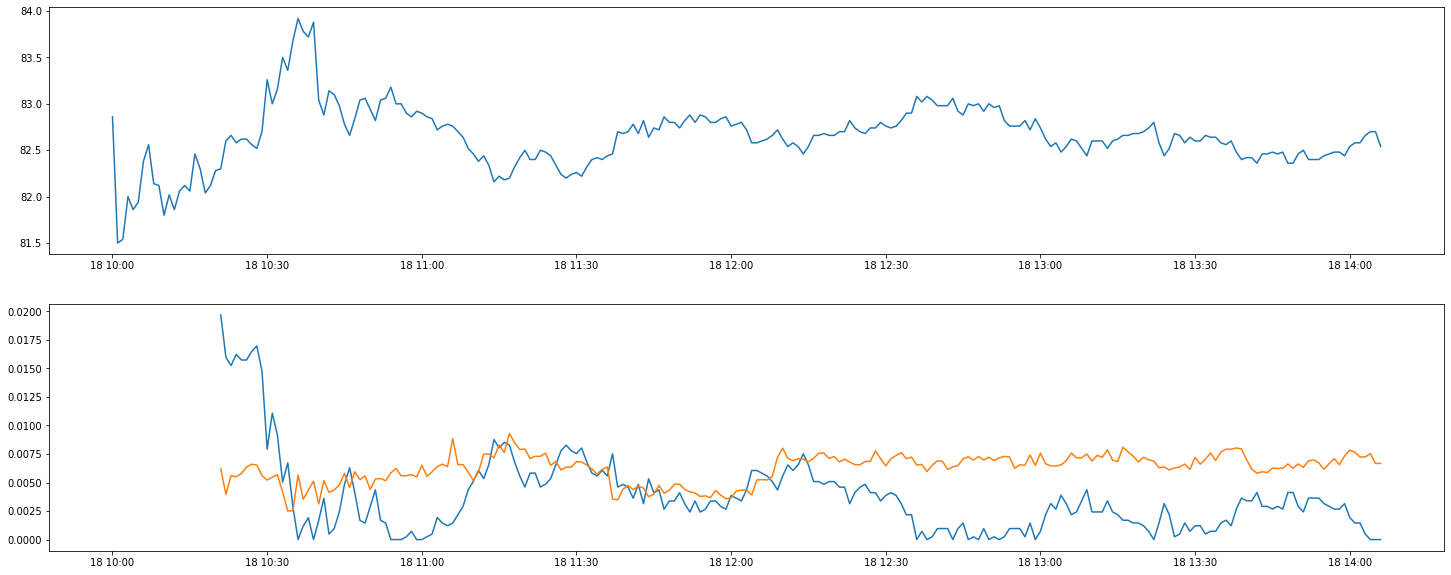

In [16]:
day = np.datetime64('2020-06-18')
ticker='AFLT'
day_result = result[(result['ticker'] == ticker) & (result['date'] == day)]
day_price = ticker2df[ticker][ticker2df[ticker]['date'] == day]#['<OPEN>']


fig=plt.figure(figsize=(25,10))
plt.title(ticker)
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)

ax1.plot(day_price['datetime'].values, day_price['<OPEN>'])
ax2.plot(day_result['corn_datetime'].values, day_result['y'].values)
ax2.plot(day_result['corn_datetime'].values, day_result['pred_y'].values)

In [33]:
class Model:
    def __init__(self, base_model):
        self.base_model = base_model
        
    def predict_moments(self, X):
        #pred = self.base_model.predict_proba(X.drop(['corn_datetime', 'ticker'], axis=1))[:, 1]
        pred = self.base_model.predict(X.drop(['corn_datetime', 'ticker'], axis=1))

        buy_moments = X[pred > 0.0][['ticker', 'corn_datetime']]
        source_pred = pd.DataFrame()
        source_pred['datetime'] = X['corn_datetime']
        source_pred['ticker'] = X['ticker']
        source_pred['pred'] = pred
        source_pred['date'] = source_pred['datetime'].astype('datetime64[D]')

        return buy_moments, source_pred
        
        
strategy = Strategy(Model(lgb), take_profit_coef=1+0.005, stop_loss_coef=1-0.005, broker_comission=0.0005, close_interval=np.timedelta64(1,'h'))   

In [34]:
strategy.evaluate(ticker2df, X_val)

-2369.0210492965753

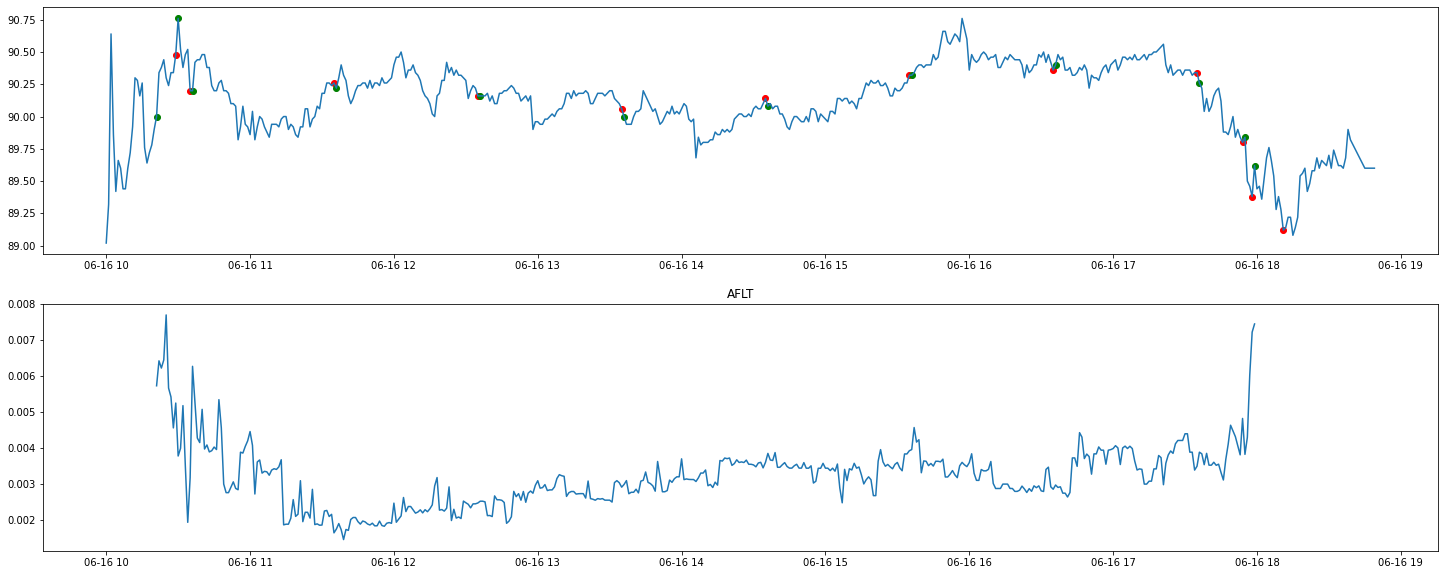

In [35]:
strategy.draw(ticker2df, 1)

In [36]:
strategy.grouped_orders

,ticker,date,abs_profit
0,AFLT,2020-06-15,1668.292529
1,AFLT,2020-06-16,-1974.248430
2,AFLT,2020-06-17,-2956.894623
3,AFLT,2020-06-18,893.829475


In [32]:
strategy.orders

,ticker,buy_datetime,sell_datetime,profit,buy_price,sell_price,abs_profit,time_in_order,date
0,AFLT,2020-06-15 10:27:00,2020-06-15 10:44:00,0.004673,85.06,85.50,467.281919,00:17:00,2020-06-15
1,AFLT,2020-06-15 11:13:00,2020-06-15 11:37:00,0.004610,86.10,86.54,461.033682,00:24:00,2020-06-15
2,AFLT,2020-06-17 12:53:00,2020-06-17 13:02:00,-0.006573,88.92,88.38,-657.287449,00:09:00,2020-06-17
3,AFLT,2020-06-17 13:03:00,2020-06-17 13:11:00,-0.008177,88.58,87.90,-817.667645,00:08:00,2020-06-17
4,AFLT,2020-06-17 13:14:00,2020-06-17 13:20:00,0.004948,88.10,88.58,494.835414,00:06:00,2020-06-17
5,AFLT,2020-06-17 13:21:00,2020-06-17 13:29:00,0.005152,88.46,88.96,515.227221,00:08:00,2020-06-17


In [44]:
X_val.shape

(6409, 50)

In [53]:
strategy.orders

,ticker,buy_datetime,sell_datetime,profit,buy_price,sell_price,abs_profit,time_in_order,date
0,AFLT,2020-06-15 10:21:00,2020-06-15 10:45:00,0.009651,84.72,85.58,965.108593,00:24:00,2020-06-15
1,AFLT,2020-06-15 10:48:00,2020-06-15 11:44:00,0.009766,85.72,86.60,976.598227,00:56:00,2020-06-15
2,AFLT,2020-06-15 11:45:00,2020-06-15 13:53:00,-0.012498,86.68,85.64,-1249.815413,02:08:00,2020-06-15
3,AFLT,2020-06-15 13:54:00,2020-06-15 16:39:00,0.009759,85.78,86.66,975.880159,02:45:00,2020-06-15
4,AFLT,2020-06-15 16:40:00,2020-06-15 18:33:00,0.009685,86.40,87.28,968.518519,01:53:00,2020-06-15
5,AFLT,2020-06-16 10:21:00,2020-06-16 18:15:00,-0.010722,90.00,89.08,-1072.222222,07:54:00,2020-06-16
6,AFLT,2020-06-17 10:21:00,2020-06-17 12:52:00,-0.011202,89.70,88.74,-1120.234114,02:31:00,2020-06-17
7,AFLT,2020-06-17 12:53:00,2020-06-17 13:11:00,-0.011971,88.92,87.90,-1197.098516,00:18:00,2020-06-17
8,AFLT,2020-06-17 13:12:00,2020-06-17 13:29:00,0.009720,88.06,88.96,972.030434,00:17:00,2020-06-17
9,AFLT,2020-06-17 13:31:00,2020-06-17 18:11:00,-0.014458,88.84,87.60,-1445.767672,04:40:00,2020-06-17


In [ ]:
draw_orders(date)

In [143]:
X_val[:3]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,ticker,corn_datetime
0,-0.027938,0.004382,-0.031772,-0.012431,0.007261,1.037341,0.577370,0.324036,0.270138,0.196281,...,4.0,1.0,0.971275,0.966912,0.997455,0.966912,0.003454,0.000909,AFLT,2020-05-18 10:21:00
1,-0.027664,0.004382,-0.031772,-0.012439,0.007267,1.037341,0.578032,0.324036,0.270414,0.196492,...,4.0,1.0,0.971275,0.966912,0.997455,0.966912,0.003182,0.001182,AFLT,2020-05-18 10:22:00
2,-0.029581,0.004382,-0.031772,-0.012447,0.007274,1.037341,0.578789,0.324036,0.270785,0.196728,...,5.0,0.0,0.966912,NaN,0.997455,0.966912,0.000727,NaN,AFLT,2020-05-18 10:23:00


In [144]:
y_val

array([0.        , 0.00197573, 0.00084579, ..., 0.00335345, 0.00425151,
       0.00156215])

(array([ 45., 126., 215., 280., 290., 300., 288., 231., 152.,  73.]),
 array([0.0340979 , 0.12758671, 0.22107551, 0.31456432, 0.40805313,
        0.50154193, 0.59503074, 0.68851954, 0.78200835, 0.87549715,
        0.96898596]),
 <a list of 10 Patch objects>)

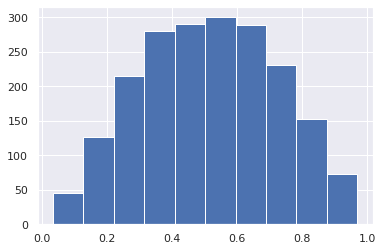

In [53]:
plt.hist(pred_proba)

In [43]:
y_val

array([0.0022457 , 0.00373134, 0.0030074 , ..., 0.00159067, 0.00479616,
       0.00370272])

In [37]:
pred_proba

array([0.74425161, 0.75724756, 0.27640063, ..., 0.71295781, 0.60290524,
       0.8223023 ])

In [46]:
X['y'] = y

(array([116.,  89.,  49.,  19.,  10.,   9.,   4.,   1.,   1.,   2.]),
 array([6.02280216e-05, 8.14788228e-04, 1.56934843e-03, 2.32390864e-03,
        3.07846885e-03, 3.83302905e-03, 4.58758926e-03, 5.34214946e-03,
        6.09670967e-03, 6.85126988e-03, 7.60583008e-03]),
 <a list of 10 Patch objects>)

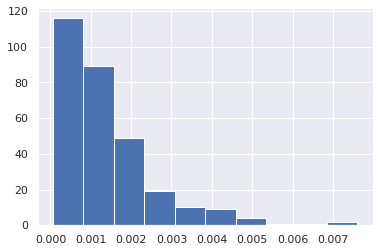

In [11]:
plt.hist(y)

In [ ]:
lgb.feature_importances_

In [ ]:
plt.plot(lgb.feature_importances_)

In [ ]:
plt.plot(lgb.feature_importances_)

In [ ]:
try:
    del X_val['profit']
    del X_val['profit_abs']
except:
    None

pred_proba = lgb.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1)[best_feat_idxs])[:, 1]
#pred_proba = lgb.predict(X_val.drop(['corn_date', 'ticker'], axis=1))

plt.plot(pred_proba)
plt.show()

# pred_proba_2 = lgb_2.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_2)
# plt.show()

# pred_proba_3 = lgb_3.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_3)

In [ ]:
plt.hist(pred_proba, bins=100)
plt.show()

In [ ]:
top_idxs = np.where(pred_proba > 0.7)[0]
len(top_idxs)

In [ ]:
y_val.mean(), y_val[top_idxs].mean()

In [ ]:
y_val.mean(), y_val[top_idxs].mean()

In [ ]:
from utils import *

y_val_profit = calc_target(val_target_dfs, single_profit_2, target_df_2_one_day_series)

In [ ]:
X_val['profit'] = y_val_profit
day_cnt_df = X_val.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_val = pd.merge(X_val, day_cnt_df, on='corn_date', how='left')
X_val['volume'] = 2500000 / X_val['cnt_per_day']
X_val['profit_abs'] = X_val['volume'] * X_val['profit']
del X_val['cnt_per_day']
del X_val['volume']

In [ ]:
X_val.loc[top_idxs].groupby('corn_date')['profit_abs'].sum()

In [ ]:
X_val.loc[top_idxs]['profit_abs'].sum()

In [ ]:
54294.45376124319
45058.54288341864

In [ ]:
249540.7438308383
238265.8202385087
182758.77619388318
124229.31720323926
91517.8617101984
84287.5011097007

In [ ]:
X_day = X_val.loc[top_idxs]
X_day = X_day[X_day['corn_date'] == datetime.strptime("20190814", "%Y%m%d").date()]

In [ ]:
X_day

In [ ]:
profit

In [ ]:
idx = 237
#for idx in top_idxs:
corn_date = X_val.loc[idx]['corn_date']
ticker = X_val.loc[idx]['ticker']

df = ticker2df[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=1))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx, profit = single_profit_2(target_series, return_idxs=True)

plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx, target_series[buy_idx], color='g')
plt.scatter(len(month_series) + sell_idx, target_series[sell_idx], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')




plt.show()
corn_date

In [ ]:
int(datetime.now().strftime('%H'))

In [ ]:
lgb

In [ ]:
import pickle
with open('models/lgb_26_09_thr04.pickle', 'wb') as f:
    pickle.dump(lgb, f)

# Inference

In [ ]:
train_dates = [datetime.today().date() - timedelta(days=x) for x in range(1, 100)]

In [ ]:
X_train, y_train_series = all_samples(ticker2df, train_dates)


In [ ]:
y_train_profit = calc_target(y_train_series, single_profit_2) 

y_train = calc_target(y_train_series, single_target_3) > 0.01

lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train)

In [ ]:
test_start_day

In [ ]:
load_tickers(data_prefix="data/current", tickers=np.array(list(ibkr_info.keys())), start_date=datetime.today().date() - timedelta(days=40), end_date=datetime.today().date(), period=3)

In [ ]:
ticker2df_test = load_dfs('data/current', np.array(list(ibkr_info.keys())))

In [ ]:
X_test, y_test_series = all_samples(ticker2df_test, [datetime.today().date()], test_mode=True)

In [ ]:
import pickle
with open('models/lgb_26_09_thr04.pickle', 'rb') as f:
    lgb = pickle.load(f)

In [ ]:
X_test

In [ ]:
# del X_test['profit']
# del X_test['profit_abs']

In [ ]:
pred_proba = lgb.predict_proba(X_test.drop(['corn_date', 'ticker'], axis=1))[:, 1]
plt.plot(pred_proba)
plt.show()


In [ ]:
16990000 * 0.039235

In [ ]:
top_idxs = np.where(pred_proba > 0.25)[0]
top_idxs

In [ ]:
ticker2price = {}

for ticker in list(X_test.loc[top_idxs, ['ticker', 'corn_date']]['ticker'].values):
    
    df = ticker2df_test[ticker]
    price = df[df['date']==datetime.today().date()]['<OPEN>'].values[0]
    
    ticker2price[ticker] = price


ticker2price

In [ ]:
y_test_profit = calc_target(y_test_series, single_profit_2)

In [ ]:
X_test['profit'] = y_test_profit
day_cnt_df = X_test.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_test = pd.merge(X_test, day_cnt_df, on='corn_date', how='left')
X_test['volume'] = 2000000 / X_test['cnt_per_day']
X_test['profit_abs'] = X_test['volume'] * X_test['profit']
del X_test['cnt_per_day']
del X_test['volume']

In [ ]:
top_idxs

In [ ]:
X_test.loc[top_idxs, ['ticker', 'corn_date']]

In [ ]:
X_test.loc[top_idxs, ['ticker', 'corn_date', 'profit', 'profit_abs']]

In [ ]:
X_test.loc[top_idxs, ['profit']].sum()

In [ ]:
X_test.loc[top_idxs, ['profit_abs']].sum()

In [ ]:
idx = 20
#for idx in top_idxs:
corn_date = X_test.loc[idx]['corn_date']
ticker = X_test.loc[idx]['ticker']

df = ticker2df_test[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=1))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx = single_profit_2(np.array([0] + list(target_series)), return_idxs=True)
plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx - 1, target_series[buy_idx - 1], color='g')
plt.scatter(len(month_series) + sell_idx - 1, target_series[sell_idx - 1], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')

# plt.axhline(y=11.573, linewidth=4, color='g')
# plt.axhline(y=11.675, linewidth=4, color='r')



plt.show()



In [ ]:
    series = np.array([0] + list(target_series))
    UPPER_COEF = 1.003
    BUY_HORIZON = 118
    can_buy = (series[2:BUY_HORIZON] <= series[1]*UPPER_COEF).max()

In [ ]:
can_buy

In [ ]:
series[2:BUY_HORIZON] <= series[1]*UPPER_COEF

In [ ]:
series

In [ ]:
datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
data_prefix='data/train'
start_date=datetime.today().date() - timedelta(days=1)
end_date = datetime.today().date() + timedelta(days=1)

ticker='LKOH'
load_single(ticker, 'data/temp', start_date, end_date, 3)


df = pd.read_csv('data/train/{}.csv'.format(ticker))
df['date'] = df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())

upd_df = pd.read_csv('data/temp/{}.csv'.format(ticker))
upd_df['date'] = upd_df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())